In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np

We create *k* actions with unit expected rewards. These expected rewards are used to create normal
 random distributions with unit variance. When an action is selected we return a reward based on the distribution for that action. 

In [3]:
k = 10
expected_rewards = np.random.normal(0, 1, size=k)

print(expected_rewards)

def action(a):
    return random.normalvariate(expected_rewards[a], 1)

[-1.97007644  1.67609044 -0.79315484  0.36586733 -1.15382742 -0.21782036
  0.47223914  1.30923416  0.46435641 -0.73350738]


We'll now create the functionality to update value estimates. We use a sample average method where we simply average all of the rewards obtained from the selected action so far.

In [4]:
estimates = [0] * k
times_selected = [0] * k

def sample_average_estimate(a, r):
    times_selected[a] += 1
    estimates[a] = estimates[a] + (r - estimates[a]) / times_selected[a]
    

Let's try a simple greedy action selection method. 

In [5]:
def greedy_select():
    # Select the indicies of all the apparent optimal actions
    max_actions = [action for action, value in enumerate(estimates) if value == max(estimates)]
    # Return a random choice from them
    return random.choice(max_actions)

In [6]:
for t in range(1000):
    a = greedy_select()
    r = action(a)
    sample_average_estimate(a, r)

print(estimates)

[0, 0, 0, 0.3964095323568621, 0, -0.5000277781509527, 0, 0, 0, 0]


We can see that several estimates are not updating because we are not exploring at all. 

To fix this, let's try a slightly more sophisticated action selection method which randomly selects actions with some probability.

In [7]:
def epsilon_greedy_select(epsilon):
    if random.random() < epsilon:
        return random.choice(range(k))
    return greedy_select()

estimates = [0] * k
times_selected = [0] * k

for t in range(1000):
    a = epsilon_greedy_select(0.10)
    r = action(a)
    sample_average_estimate(a, r)

print(estimates)

[-1.9777542866529962, 1.6965511106316378, -0.6438048694608566, 0.6676739103743137, -1.0937005928444519, 0.5275658834711926, 0.6885268895333887, 1.3777006136314989, 0.16148944000549437, -0.3911308534358151]


To compare the two methods, we can create a testbed. Here, we compare the greedy method with two epsilon methods with epsilon-values of 0.01 and 0.1. We run each method a certain number of times to a certain number of timesteps. Each run, we create a new set of actions.

In [8]:
runs = 1000
steps = 1000

rewards_greedy = []
rewards_e_greedy = []
rewards_e_greedy2 = []

for run in range(runs):
    row = []
    expected_rewards = [random.normalvariate(0, 1) for _ in range(k)]
    estimates = [0] * k
    times_selected = [0] * k
    for t in range(steps):
        a = greedy_select()
        r = action(a)
        sample_average_estimate(a, r)
        row.append(r)
    rewards_greedy.append(row)

for run in range(runs):
    row = []
    expected_rewards = [random.normalvariate(0, 1) for _ in range(k)]
    estimates = [0] * k
    times_selected = [0] * k
    for t in range(steps):
        a = epsilon_greedy_select(0.01)
        r = action(a)
        sample_average_estimate(a, r)
        row.append(r)
    rewards_e_greedy.append(row)

for run in range(runs):
    row = []
    expected_rewards = [random.normalvariate(0, 1) for _ in range(k)]
    estimates = [0] * k
    times_selected = [0] * k
    for t in range(steps):
        a = epsilon_greedy_select(0.1)
        r = action(a)
        sample_average_estimate(a, r)
        row.append(r)
    rewards_e_greedy2.append(row)

rewards_greedy_average = np.mean(rewards_greedy, axis=0)
rewards_e_greedy_average = np.mean(rewards_e_greedy, axis=0)
rewards_e_greedy2_average = np.mean(rewards_e_greedy2, axis=0)

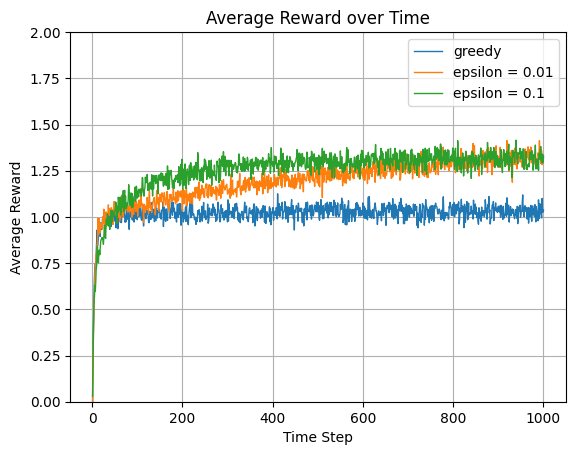

In [9]:
plt.plot(range(1, len(rewards_greedy_average) + 1), rewards_greedy_average, label="greedy", linewidth=1)
plt.plot(range(1, len(rewards_e_greedy_average) + 1), rewards_e_greedy_average, label="epsilon = 0.01", linewidth=1)
plt.plot(range(1, len(rewards_e_greedy2_average) + 1), rewards_e_greedy2_average, label="epsilon = 0.1", linewidth=1)
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time')
plt.legend()
plt.grid(True)
plt.ylim(0, 2)
plt.show()

We now experiment with nonstationary problems, where the expected values go on random walks. We will show that the sample average performs worse long term than a weighted average value estimation method.

In [14]:
def update_rewards(qs):
    for i in range(len(qs)):
        qs[i] += random.normalvariate(0, 0.01)
    return qs

def weighted_average_estimate(a, r, alpha):
    estimates[a] = estimates[a] + (r - estimates[a]) * alpha

runs = 500
steps = 10000

rewards_e_greedy = []
rewards_e_greedy_weighted = []

for run in range(runs):
    row = []
    expected_rewards = [random.normalvariate(0, 1) for _ in range(k)]
    estimates = [0] * k
    times_selected = [0] * k
    for t in range(steps):
        expected_rewards = update_rewards(expected_rewards)
        a = epsilon_greedy_select(0.1)
        r = action(a)
        sample_average_estimate(a, r)
        row.append(r)
    rewards_e_greedy.append(row)

for run in range(runs):
    row = []
    expected_rewards = [random.normalvariate(0, 1) for _ in range(k)]
    estimates = [0] * k
    for t in range(steps):
        expected_rewards = update_rewards(expected_rewards)
        a = epsilon_greedy_select(0.1)
        r = action(a)
        weighted_average_estimate(a, r, 0.1)
        row.append(r)
    rewards_e_greedy_weighted.append(row)

rewards_e_greedy_average = np.mean(rewards_e_greedy, axis=0)
rewards_e_greedy_weighted_average = np.mean(rewards_e_greedy_weighted, axis=0)

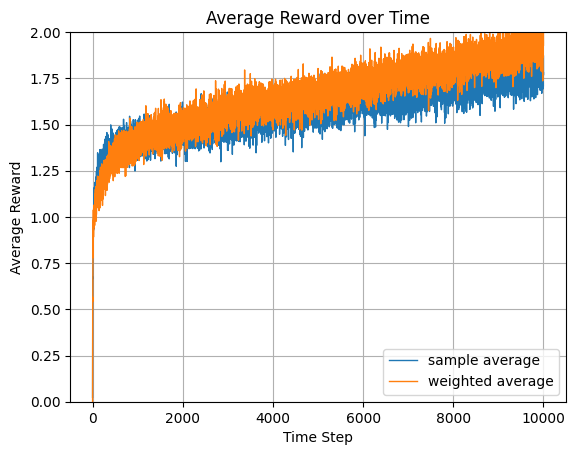

In [15]:
plt.plot(range(1, steps + 1), rewards_e_greedy_average, label="sample average", linewidth=1)
plt.plot(range(1, steps + 1), rewards_e_greedy_weighted_average, label="weighted average", linewidth=1)
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time')
plt.legend()
plt.grid(True)
plt.ylim(0, 2)
plt.show()